# New Privately-Owned Housing Units Started: Total Units

https://fred.stlouisfed.org/series/HOUSTNSA

## Load data

In [1]:
PATH = "../../../data/fred/HOUSTNSA.csv"

In [2]:
import pandas as pd
df = pd.read_csv(PATH)

df

,observation_date,HOUSTNSA
0,1959-01-01,96.2
1,1959-02-01,99.0
...,...,...
794,2025-03-01,111.3
795,2025-04-01,123.7


## Preprocess data

### Datetime column object

In [3]:
COLUMN_DATETIME = "observation_date"

x = pd.to_datetime(df[COLUMN_DATETIME], utc=False)
x

0     1959-01-01
1     1959-02-01
         ...    
794   2025-03-01
795   2025-04-01
Name: observation_date, Length: 796, dtype: datetime64[ns]

In [4]:
df[COLUMN_DATETIME] = x

### Local timezones

In [5]:
TIMEZONE = None

x = df[COLUMN_DATETIME]

try:    
    x = x.dt.tz_convert(TIMEZONE)
except Exception as e:
    print(e)

x

Cannot convert tz-naive timestamps, use tz_localize to localize


0     1959-01-01
1     1959-02-01
         ...    
794   2025-03-01
795   2025-04-01
Name: observation_date, Length: 796, dtype: datetime64[ns]

In [6]:
df[COLUMN_DATETIME] = x

### Available series inside dataset

In [7]:
df

,observation_date,HOUSTNSA
0,1959-01-01,96.2
1,1959-02-01,99.0
...,...,...
794,2025-03-01,111.3
795,2025-04-01,123.7


In [8]:
COLUMN_CATEGORIES = []

df[COLUMN_CATEGORIES].drop_duplicates().style

0
1
2
3
4
5
6
7
8
9
10


### Set index

The index is composed by the columns that uniquely identify the rows. The datetime column must be present.

In [9]:
COLUMN_CATEGORIES = []

idx = COLUMN_CATEGORIES + [COLUMN_DATETIME]
x = df.set_index(idx).sort_index()

x

,HOUSTNSA
observation_date,
1959-01-01,96.2
1959-02-01,99.0
...,...
2025-03-01,111.3
2025-04-01,123.7


In [10]:
x.index.is_unique

True

In [11]:
df = x.copy()

### Select values column

In [12]:
COLUMN_VALUES = "HOUSTNSA"

x = df[COLUMN_VALUES]
x

observation_date
1959-01-01     96.2
1959-02-01     99.0
              ...  
2025-03-01    111.3
2025-04-01    123.7
Name: HOUSTNSA, Length: 796, dtype: float64

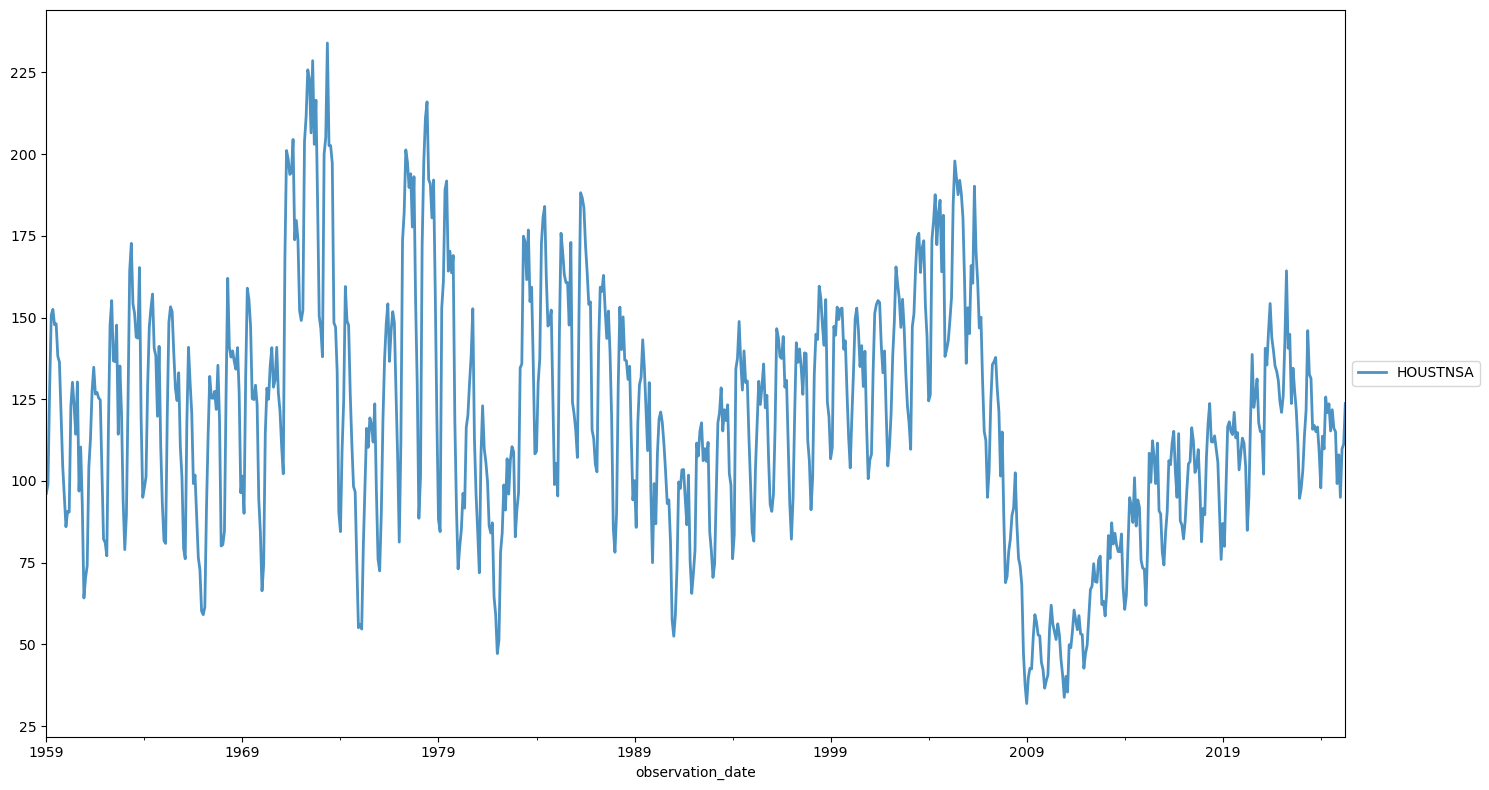

In [13]:
plot = x.unstack(level=COLUMN_CATEGORIES).plot(figsize=(15, 8), linewidth=2, alpha=0.8)
plot.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plot.figure.tight_layout()

In [14]:
series = x.copy()

### Filter one time series

To get a table with the unique datetime index of the series, and the time series values.

<div class="alert alert-warning">
Not necessary if the data already represents a time series with unique datetime values.
</div>


In [15]:
CATEGORIES = ()

x = series.loc[CATEGORIES]
x

observation_date
1959-01-01     96.2
1959-02-01     99.0
              ...  
2025-03-01    111.3
2025-04-01    123.7
Name: HOUSTNSA, Length: 796, dtype: float64

In [16]:

from modules import utils
utils.configure_plotly_template(showlegend=True)

In [17]:
x.plot()

In [18]:
series = x.copy()

### Filter datetime range

<div class="alert alert-warning">
Not necessary if you are interested in the whole time series. Although, it's advised to filter out outliers and incomplete data to get full periods, like full years, months, etc.
</div>

In [19]:
START, END = '2000', '2020'

In [20]:
x = series.loc[START:END]
x

observation_date
2000-01-01    104.0
2000-02-01    119.7
              ...  
2020-11-01    117.8
2020-12-01    115.1
Name: HOUSTNSA, Length: 252, dtype: float64

In [21]:
series = x.copy()

### Aggregate

**Check if you need to aggregate your data:**

- ✅ **Keep as-is** if data is already at appropriate frequency (monthly, quarterly, etc.)
- 🔄 **Aggregate first** if data is too granular for your seasonal question:
  - **Annual seasonality** → Aggregate to monthly
  - **Weekly patterns** → Aggregate to daily  
  - **Daily patterns** → Aggregate to hourly

**Rule of Thumb:**

Match your data frequency to the seasonal cycle you want to study. Most seasonal business analysis works best with **monthly data** to capture yearly patterns.

**Note**: You need at least 3-5 complete seasonal cycles for reliable decomposition results.

In [22]:
RULE = 'ME'

In [23]:
x = series.resample(RULE).sum()
x.plot()

In [24]:
series = x.copy()

## Individual component behaviour based on model

Components:

- Trend (T)
- Seasonality (S)
- Residual or Irregular Component (I)

Models:

- Additive model: $y_t = T_t + S_t + e_t$
- Multiplicative model: $y_t = T_t \times S_t \times e_t$

### Additive model

In [25]:
import statsmodels.api as sm

In [26]:
PERIOD = 12

result = sm.tsa.seasonal_decompose(series, model='additive', period=PERIOD)

x = (x
 .to_frame()
 .assign(
    trend = result.trend,
    seasonal = result.seasonal,
    residual = result.resid)
 .dropna())

x

,HOUSTNSA,trend,seasonal,residual
observation_date,,,,
2000-07-31,135.0,130.816667,12.164132,-7.980799
2000-08-31,141.4,130.437500,7.532049,3.430451
...,...,...,...,...
2020-05-31,95.1,113.800000,12.957049,-31.657049
2020-06-30,118.8,114.683333,14.025590,-9.908924


In [27]:
x['model_result'] = x.trend + x.seasonal + x.residual
x

,HOUSTNSA,trend,seasonal,residual,model_result
observation_date,,,,,
2000-07-31,135.0,130.816667,12.164132,-7.980799,135.0
2000-08-31,141.4,130.437500,7.532049,3.430451,141.4
...,...,...,...,...,...
2020-05-31,95.1,113.800000,12.957049,-31.657049,95.1
2020-06-30,118.8,114.683333,14.025590,-9.908924,118.8


In [28]:
dfs = {}
dfs['additive'] = x

### Multiplicative model

In [29]:
result = sm.tsa.seasonal_decompose(series, model='multiplicative', period=PERIOD)

x = (series
 .to_frame()
 .assign(
    trend = result.trend,
    seasonal = result.seasonal,
    residual = result.resid)
 .dropna())

x

,HOUSTNSA,trend,seasonal,residual
observation_date,,,,
2000-07-31,135.0,130.816667,1.121423,0.920240
2000-08-31,141.4,130.437500,1.074003,1.009349
...,...,...,...,...
2020-05-31,95.1,113.800000,1.120674,0.745691
2020-06-30,118.8,114.683333,1.145181,0.904570


In [30]:
x['model_result'] = x.trend * x.seasonal * x.residual
x

,HOUSTNSA,trend,seasonal,residual,model_result
observation_date,,,,,
2000-07-31,135.0,130.816667,1.121423,0.920240,135.0
2000-08-31,141.4,130.437500,1.074003,1.009349,141.4
...,...,...,...,...,...
2020-05-31,95.1,113.800000,1.120674,0.745691,95.1
2020-06-30,118.8,114.683333,1.145181,0.904570,118.8


In [31]:
dfs['multiplicative'] = x

## Model comparison

### Numerical

In [32]:
df = pd.concat(dfs, axis=1).melt(ignore_index=False).reset_index()
df.columns = ["month", "model", "component", "value"]

In [33]:
df

,month,model,component,value
0,2000-07-31,additive,HOUSTNSA,135.0
1,2000-08-31,additive,HOUSTNSA,141.4
...,...,...,...,...
2398,2020-05-31,multiplicative,model_result,95.1
2399,2020-06-30,multiplicative,model_result,118.8


## Visual comparison

In [34]:
import plotly.express as px

fig = px.line(
    data_frame=df,
    x='month',
    y='value',
    color='component',
    facet_col='model',
    facet_row='component',
    width=1500,
    height=1000,
    facet_col_spacing=0.1,
)

fig.update_yaxes(matches=None)

for attr in dir(fig.layout):
    if attr.startswith("yaxis"):
        axis = getattr(fig.layout, attr)
        if axis:
            axis.showticklabels = True
        
fig